<http://www.atmarkit.co.jp/ait/articles/1311/05/news003.html>

# ITエンジニアのためのデータサイエンティスト養成講座（6）
回帰分析I：回帰分析って何？ から、最小二乗法、モデル評価、妥当性検討の実際まで


In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use('ggplot')

たとえば身長と体重の関係を考えたとき、「体重は身長に比例する」という仮説を立てると、

**y = ax + b**  
**[体重] = [身長] x [係数a] + [定数b]**

というモデルを作ることになる。係数aと定数bを求めてモデルを完成させるのが回帰分析。

最小二乗法をつかってa、bを求めてみる。

In [25]:
# csv読み込み
df = pd.read_csv('data/children_data2005_08_130819.csv', encoding='Shift_JIS', header=[0,1])
df.columns = df.columns.get_level_values(0)   #2つめの列ヘッダ削除
df.head()

,番号,計測年,計測月,性別,上半身着衣,下半身着衣,足部着衣,年齢,身長（文部省式）,身長（アントロポメータ）,...,第３指爪基部厚,第３指爪基部幅,第３指爪基部長さ,第５指爪基部厚,第５指爪基部幅,第５指爪基部長さ,握力（右手）,握力（左手）,握力計 種類,特記事項
0,1,2005年,11月,男の子,（不明）,（不明）,（不明）,4.47,NaN,1022,...,9,11,9,8,10,7,NaN,NaN,NaN,NaN
1,2,2005年,11月,男の子,（不明）,（不明）,（不明）,2.11,NaN,835,...,7,9,5,6,7,5,NaN,NaN,NaN,NaN
2,3,2005年,11月,女の子,（不明）,（不明）,（不明）,3.56,NaN,958,...,8,10,7,7,9,8,NaN,NaN,NaN,NaN
3,4,2005年,11月,男の子,（不明）,（不明）,（不明）,2.91,NaN,909,...,9,10,9,8,8,6,NaN,NaN,NaN,NaN
4,5,2005年,11月,男の子,（不明）,（不明）,（不明）,4.25,NaN,1044,...,9,12,11,8,11,8,NaN,NaN,NaN,NaN


In [26]:
# 身長や体重がNaNになっているデータがある
any(df.ix[:, [9, 10]].isnull())

True

In [27]:
# 身長や体重がNaNになっているデータがある
df.ix[150:165, [0, 9, 10]]  #index=150〜165、列は0(番号),9(身長),10(体重)を表示。 「番号」列は重複があるので注意

,番号,身長（アントロポメータ）,体重
150,148,677,NaN
151,149,698,8.685
152,149,692,NaN
153,150,692,8.400
154,151,727,9.400
155,151,730,NaN
156,152,770,11.500
157,152,779,NaN
158,153,NaN,10.950
159,153,794,NaN


In [28]:
# 身長や体重がNaNのデータは除去
# 除去するために、notnullのテスト関数を使う。数値として有効な場合にTrueを返す関数
df_sample_weight = df.ix[150:165, 10]  #列10は体重
df_sample_weight.notnull()

150    False
151     True
152    False
153     True
154     True
155    False
156     True
157    False
158     True
159    False
160     True
161    False
162     True
163    False
164     True
165    False
Name: 体重, dtype: bool

In [29]:
# インデクシングで体重が数値として有効な行だけ残す例
df_sample_weight[df_sample_weight.notnull()]

151     8.685
153     8.400
154     9.400
156    11.500
158    10.950
160    10.550
162     9.750
164    15.400
Name: 体重, dtype: float64

In [30]:
# 以上をふまえて、全体のデータから身長、体重ともに有効なデータだけ抽出する
df = df[df.ix[:,9].notnull()]   #身長
df = df[df.ix[:,10].notnull()]  #体重

# 中身を確認
df.ix[150:165, [0,9,10]]  #NaNの行が削除されている

,番号,身長（アントロポメータ）,体重
151,149,698,8.685
153,150,692,8.400
154,151,727,9.400
156,152,770,11.500
160,154,776,10.550
162,155,753,9.750
164,156,975,15.400


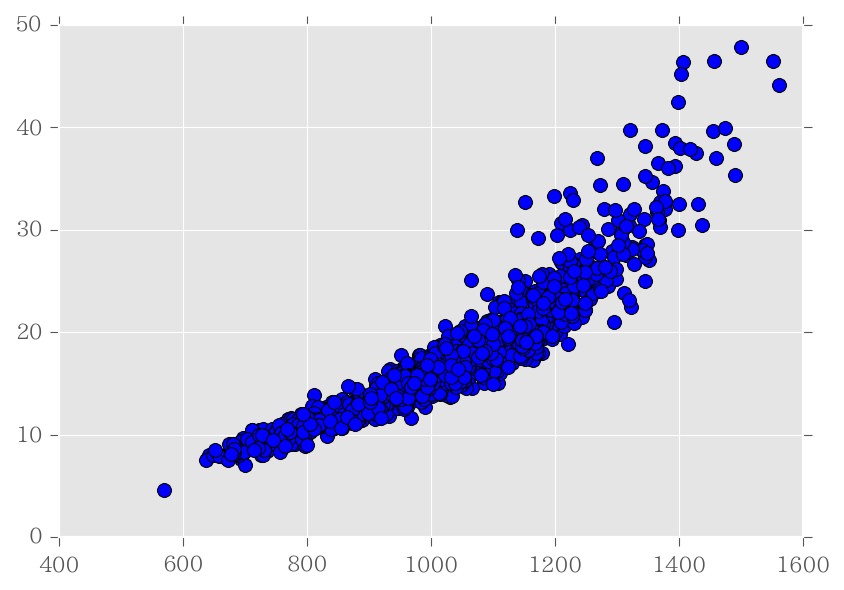

In [31]:
# 身長、体重の軸を取得
height = df.ix[:,9]
weight = df.ix[:,10]

# グラフで可視化
matplotlib.pyplot.plot(height, weight, 'bo')

グラフを見ると微妙にまがっているようだが、直線とみなすことにして、先ほどの「体重は身長に線形に比例する」という過程に基づいてモデル化する。
**[体重] = [身長] x [係数a] + [定数b]** --- モデル(1)

pandasには単回帰分析をするための便利なols関数があるので最小二乗法で簡単に係数a、定数bが求められる。

ols関数は、目的変数y, 説明変数x、切片を持つかどうかを渡すと最小二乗法でモデルを作成してくれる。

In [32]:
model = pd.ols(y=weight, x=height, intercept=True)
model


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         1602
Number of Degrees of Freedom:   2

R-squared:         0.8445
Adj R-squared:     0.8444

Rmse:              2.1957

F-stat (1, 1600):  8691.3653, p-value:     0.0000

Degrees of Freedom: model 1, resid 1600

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0336     0.0004      93.23     0.0000     0.0329     0.0343
     intercept   -17.2343     0.3742     -46.06     0.0000   -17.9677   -16.5009
---------------------------------End of Summary---------------------------------

係数aは0.0336, 定数bは-17.2343となった。

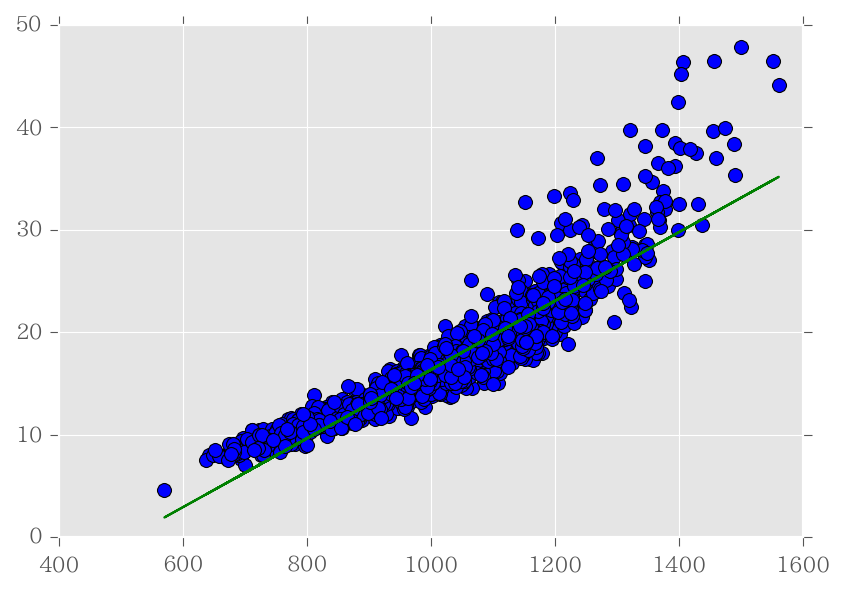

In [33]:
#両方をグラフにプロットしてみる
matplotlib.pyplot.plot(height, weight, 'bo')
matplotlib.pyplot.plot(model.x['x'], model.y_fitted, 'g-')

↑をみるとだいたい合っている感があるが、モデルの妥当性を検証する方法がある。

- 決定係数
- F検定
- t検定

の3つを使って妥当性を検証する。

### 決定係数
決定係数は0〜1の間の値を取る（相関係数の2乗）。0の時モデルに一致しているデータは0%、1の時100%。
今回のモデルではR-squared: 0.8445が決定係数で、84%が説明できている。

### F検定
ばらつきが同じ感じか、ズレているか。

F-stat (1, 1600):  8691.3653, p-value:     0.0000

のp-valueを見る。

このモデルの一致は偶然起きたものか？偶然とは思えないものなのか？

5%の確率で偶然起きること比較してそれよりも低い確率でしか起きないようだ  
→これは偶然ではなくて意味があることだ。  
→有意水準5%(0.05)で有意差がある。  

有意水準は5%やより厳密な1%が使われる。今回の例では有意水準1%でも有意差がある。

### t検定
モデルの各パラメータの妥当性を検証する。

- 係数a  t-stat=93.23     p-value=0.0000
- 定数b  t-stat=-46.06    p-value=0.0000

a,bともにp-valueは小さく、有意水準1%(0.01)で有意差がある。  



## より精度の高いモデルを検討

すでに十分精度のよいモデルだと思われるが、もっと精度の高いモデルを検討してみる。

グラフをみると、身長が低いときの体重増加量よりも、身長が高くなってからの体重の増加量が大きく、身長と体重の関係は直線ではなく曲線と過程することもできる。

- 体積は長さの3乗に比例
- 重さは体積に比例

→体重は身長の3乗に比例する？という仮説

**[体重] = [身長]^3 x [係数a'] + [定数b']** - モデル2


In [37]:
model2 = pd.ols(y=weight, x=height**3, intercept=True)
model2


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         1602
Number of Degrees of Freedom:   2

R-squared:         0.9002
Adj R-squared:     0.9001

Rmse:              1.7594

F-stat (1, 1600): 14428.5269, p-value:     0.0000

Degrees of Freedom: model 1, resid 1600

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0000     0.0000     120.12     0.0000     0.0000     0.0000
     intercept     5.1931     0.1098      47.31     0.0000     4.9779     5.4082
---------------------------------End of Summary---------------------------------

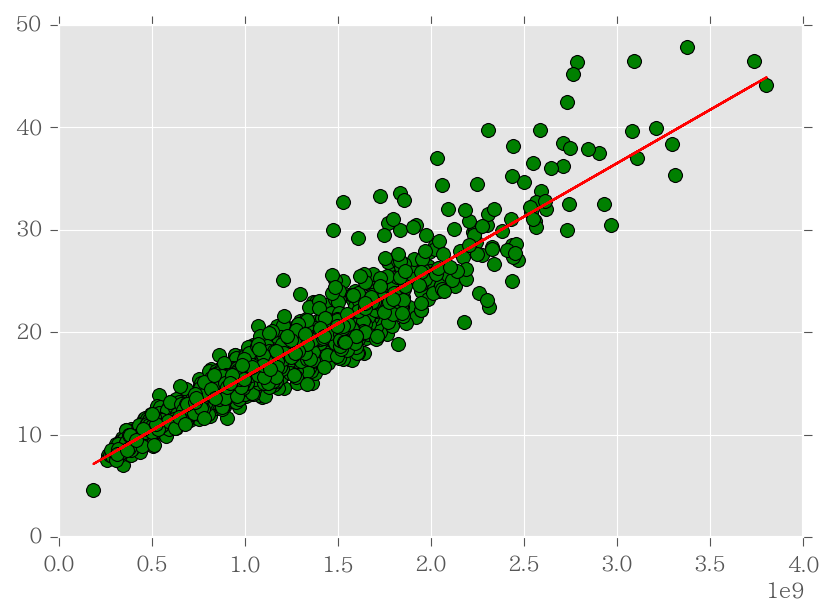

In [46]:
matplotlib.pyplot.plot(model2.x['x'], model2.y, 'go')
matplotlib.pyplot.plot(model2.x['x'], model2.y_fitted, 'r-')


決定係数が0.9002で、前のモデルよりも5%以上精度がよい結果になっている